# Clean Tweets Analysis

Tweets are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape`. To collect Tweets incrementally, the `scrape` module makes use of `since_id` and `max_id` paramaters issued by [Twitter API](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline).

All Tweets are filter by a given date interval, that is currently all Tweets from June 1st, 2022 (2022-06-01).


Tweets data schema:

Column                    | Description                                                           | Data Type
------------------------- | --------------------------------------------------------------------- | -------
id                        | Numeric Tweet identifier                                              | int64
created_at                | Date and time of Tweet creation                                       | datetime64[ns, UTC]
user_id                   | Tweet author                                                          | int64
full_text                 | Tweet full text                                                       | string
hashtags                  | Hashtags used in Tweet                                                | object
user_mentions             | Users mentioned in Tweet                                              | object
is_retweet                | Tweet is a Retweet                                                    | bool
retweet_created_at        | Date and time of Retweet creation                                     | datetime64[ns, UTC]
retweet_timedelta_sec     | Time elapsed between original Tweet and Retweet creation              | Int64 (nullable)
retweet_from_user_id      | Retweet author                                                        | Int64 (nullable)
retweet_from_tweet_id     | Numeric Retweet identifier                                            | Int64 (nullable)
is_reply                  | Tweet is a reply to another Tweet                                     | bool
in_reply_to_status_id     | Original Tweet ID if this Tweet is a reply                            | Int64 (nullable)
in_reply_to_user_id       | Original Tweet's User ID if this Tweet is a reply                     | Int64 (nullable)
is_quote_status           | Tweet is a quote                                                      | bool
favorite_count            | Number of times a Tweet was favorited (liked)                         | int64
possibly_sensitive        | Tweet contains sensitive content                                      | bool
week                      | Month of Tweet creation                                               | string
month                     | Week of Tweet creation                                                | string
langid                    | Tweet language                                                        | string

In [2]:
from twitter_scraper import settings
from twitter_scraper import utils
from twitter_scraper.clean.users import USER_DTYPE
from twitter_scraper.clean.tweets import TWEET_DTYPE

import matplotlib.pyplot as plt
import pandas as pd

clean_users_dfs = utils.pd_read_multiple(
    directory=settings.CLEAN_USERS_DIR, 
    read_fn=pd.read_csv, 
    dtype=USER_DTYPE,
    parse_dates=['created_at']
)

clean_tweets_dfs = utils.pd_read_multiple(
    directory=settings.CLEAN_TWEETS_DIR, 
    read_fn=pd.read_csv, 
    dtype=TWEET_DTYPE,
    parse_dates=['created_at', 'retweet_created_at']
)

users_df = pd.concat(clean_users_dfs)
tweets_df = pd.concat(clean_tweets_dfs)

unique_months = tweets_df.month.unique()
stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users_df[users_df.is_croatian == True])),
        '{:,}'.format(len(tweets_df.user_id.unique())),
        '{:,}'.format(len(tweets_df)),
        tweets_df['created_at'].min(),
        tweets_df['created_at'].max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)
stats_df

,Tweets Data
Croatian Users (global) #,"32,328"
Croatian Users (tweets) #,"9,305"
Tweets #,"1,866,432"
Earliest Tweet date,2022-06-01 00:00:00+00:00
Latest Tweet date,2022-11-11 20:27:49+00:00


In [3]:
tweets_view = tweets_df[[
    'id',
    'hashtags',
    'user_mentions',
    'retweet_from_user_id',
    'retweet_from_tweet_id',
    'in_reply_to_user_id',
    'in_reply_to_status_id',
    'favorite_count',
    'langid',
    'user_id',
    'created_at',
    'retweet_created_at',
    'retweet_timedelta_sec',
    'month',
    'week',
    'possibly_sensitive'
]].rename(
    columns={
        'langid': 'lang',
    }
).merge(users_df[['user_id', 'screen_name', 'description']].rename(
    columns={
        'screen_name': 'user_name',
        'description': 'user_description'
    }), on='user_id'
)

tweets_view['hashtags'] = tweets_view['hashtags'].map(eval)
tweets_view['user_mentions'] = tweets_view['user_mentions'].map(eval)

tweets_view['is_reply'] = ~tweets_view['in_reply_to_status_id'].isna()
tweets_view['is_retweet'] = ~tweets_view['retweet_from_tweet_id'].isna()

in_reply_to_user_name = tweets_view[tweets_view['is_reply'] == True][[
    'in_reply_to_user_id'
]].reset_index().merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'user_id': 'in_reply_to_user_id',
        'screen_name': 'in_reply_to_user_name'
    }), how='left', on='in_reply_to_user_id'
).set_index('index')

retweet_from_user_name = tweets_view[tweets_view['is_retweet'] == True][[
    'retweet_from_user_id'
]].reset_index().merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'user_id': 'retweet_from_user_id',
        'screen_name': 'retweet_from_user_name'
    }), how='left', on='retweet_from_user_id'
).set_index('index')

tweets_view['reply_user_name'] = in_reply_to_user_name['in_reply_to_user_name']
tweets_view['reply_user_name'] = tweets_view['reply_user_name'].fillna(tweets_view['in_reply_to_user_id'].astype(str))
tweets_view['retweet_user_name'] = retweet_from_user_name['retweet_from_user_name']
tweets_view['retweet_user_name'] = tweets_view['retweet_user_name'].fillna(tweets_view['retweet_from_user_id'].astype(str))

tweets_view = tweets_view[[
    'id',
    'created_at', 
    'user_name', 
    'user_description',
    'lang', 
    'favorite_count',
    'is_retweet',
    'retweet_created_at',
    'retweet_timedelta_sec',
    'retweet_user_name',
    'is_reply',
    'reply_user_name',
    'hashtags', 
    'user_mentions', 
    'month', 
    'week', 
    'user_id',
    'possibly_sensitive'
]]
tweets_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866432 entries, 0 to 1866431
Data columns (total 18 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   id                     int64              
 1   created_at             datetime64[ns, UTC]
 2   user_name              string             
 3   user_description       string             
 4   lang                   object             
 5   favorite_count         int64              
 6   is_retweet             bool               
 7   retweet_created_at     datetime64[ns, UTC]
 8   retweet_timedelta_sec  Int64              
 9   retweet_user_name      string             
 10  is_reply               bool               
 11  reply_user_name        string             
 12  hashtags               object             
 13  user_mentions          object             
 14  month                  string             
 15  week                   string             
 16  user_id           

## Interpreting Croatian User Tweets

[Twitter API (user_timeline)](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline) contains limitations that disrupt some Analysis performed in "Clean Tweets Analysis". One limitation is that Twitter only allows collecting up to 3,200 of a user's most recent Tweets - making it ambiguous to analyse which users tweet the most in the collected Tweets network. Considreing this limitation, the "Clean Tweets Analysis" focuses on results that show information relations, rather than information quantity. 

To provide support for the listed limitation, the Data Ingestion pipeline is ran bi-weekly, assuming that a user will not post more than 3,200 tweets in a 2-week window. This assumption is analysed by providing a question:

* What is the maximum number of tweets per user in a 2-week window?

The "Clean Tweets Analysis" aims to create questions and provide answers based on a subset of available information (columns):

Column(s)                           | Questions
----------------------------------- | ----------------------------------------------
hashtags                            | - What are the most frequently used hashtags on a monthly basis?
hashtags + user_id                  | - What hashtags are linked to a user on average in total? <br> - What hashtags are linked to a user on average on a monthly basis?
user_mentions                       | - Who are the most frequently mentioned users on a monthly basis?
is_retweet + hashtags               | - What hashtags are used in retweets against original tweets in total? <br> - How do retweet hashtags correlate to original tweet hashtags?
is_retweet + user_id                | - What is the ratio between retweets and original tweets per top 10 tweeters on a monthly basis?
is_reply + is_retweet               | - What is the ratio between retweets, replies and original tweets?
is_reply + hashtags                 | - What hashtags are used in replies against original tweets in total? <br> - How do reply hashtags correlate to original tweet hashtags?
is_reply + user_id                  | - What is the ratio between replies and original tweets per top 10 tweeters on a monthly basis?
favorite_count + user_id            | - What users have the most favorite count in total? <br> - What users have the most favorite count on a monthly basis?
favorite_count + hashtags           | - What hashtags have the most favorite count in total? <br> - What hashtags have the most favorite count on a monthly basis?
retweet_timedelta_sec               | - What is the average retweet_timedelta_sec?
retweet_timedelta_sec + user_id     | - What users retweet the fastest?
retweet_timedelta_sec + hashtags    | - What hashtags are retweeted the fastest?

In [4]:
tweets_view.sample(5)

,id,created_at,user_name,user_description,lang,favorite_count,is_retweet,retweet_created_at,retweet_timedelta_sec,retweet_user_name,is_reply,reply_user_name,hashtags,user_mentions,month,week,user_id,possibly_sensitive
102645,1573184241222942721,2022-09-23 05:35:26+00:00,jfvdvelden,Bekijk wat ik heb gepost op Google Maps Niveau...,hr,0,False,NaT,<NA>,<NA>,False,<NA>,[],[],2022-09,2022-38,245294021,False
499077,1577566274841870336,2022-10-05 07:48:04+00:00,CrazyPasko,Croatia National Team🥋 | European Championship...,hr,1,False,NaT,<NA>,<NA>,True,1462472527100448768,[],"[1462472527100448773, 1335303274451390466, 139...",2022-10,2022-40,1045229382892163073,False
791839,1575437890359857152,2022-09-29 10:50:37+00:00,BoMeetsWorld,CEO @KreativaStudio. Not to be taken seroiousl...,en,0,False,NaT,<NA>,<NA>,False,14351575,[],[14351575],2022-09,2022-39,42600233,False
375015,1584475492098641920,2022-10-24 09:22:50+00:00,Marina09222270,Nije uzela lijek a okriće na jugo...,fi,1,False,NaT,<NA>,<NA>,True,Wallyl4ever,[],[2663710320],2022-10,2022-43,1454060115007524865,False
1296164,1540708419446812677,2022-06-25 14:48:06+00:00,LivajinPP,.,hr,0,False,NaT,<NA>,<NA>,True,829248158282743808,[],[829248158282743808],2022-06,2022-25,1504887745650597895,False


In [5]:
tweets_view[['month', 'is_retweet', 'is_reply', 'id']].pivot_table(index='month', columns=['is_retweet'], aggfunc=len)

id         is_reply        
is_retweet   False   True     False   True 
month                                      
2022-06     197868   79982   197868   79982
2022-07     220066   78979   220066   78979
2022-08     245435   95134   245435   95134
2022-09     263376  104437   263376  104437
2022-10     290100  131012   290100  131012
2022-11     106099   53944   106099   53944

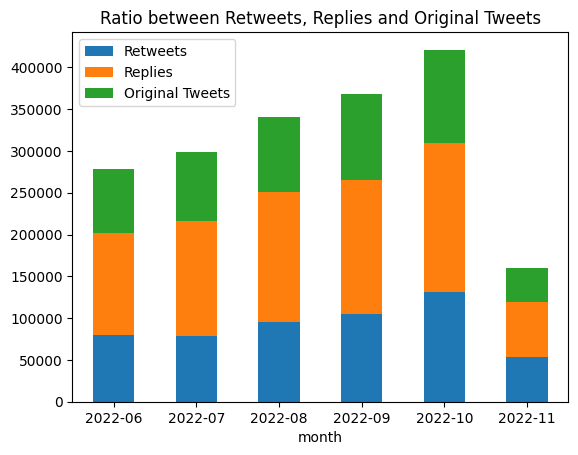

In [6]:
title = 'Ratio between Retweets, Replies and Original Tweets'

gdf = tweets_view[['id', 'month', 'is_reply', 'is_retweet']].groupby('month').agg(
    total=('id', 'size'), 
    retweets=('is_retweet', 'sum'), 
    replies=('is_reply', 'sum')
)

gdf['original'] = gdf['total'] - (gdf['retweets'] + gdf['replies'])
gdf[['retweets', 'replies', 'original']].rename(
    columns={
        'retweets': 'Retweets',
        'replies': 'Replies',
        'original': 'Original Tweets'
    }
).plot.bar(rot=0, stacked=True, title=title)
plt.show()

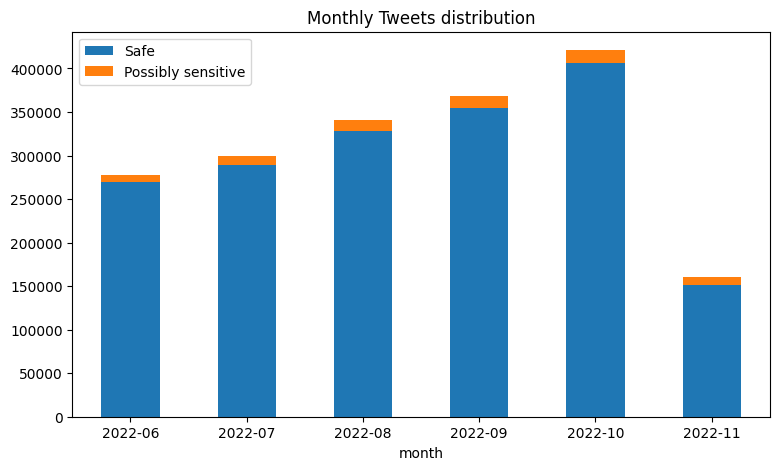

In [7]:
fig, ax = plt.subplots(1, figsize=(9, 5))

tweets_df_pivot = tweets_df[['month', 'possibly_sensitive', 'id']].pivot_table(index='month', columns=['possibly_sensitive'], aggfunc=len)
tweets_df_pivot.plot.bar(ax=ax, rot=0, stacked=True)

ax.set_title('Monthly Tweets distribution')
ax.legend(['Safe', 'Possibly sensitive'])
plt.show()

In [8]:
tweets_view[tweets_view.apply(lambda x: x['possibly_sensitive']==True and len(x['hashtags']) != 0, axis=1)][['hashtags', 'user_id']]

,hashtags,user_id
215,"[Cuckold, BBC, Hotwife, Cum]",911637468595867648
607,[HouseOfTheDragon],2203219998
611,[DWCS],2203219998
646,[dankmemes],2203219998
649,[dankmemes],2203219998
...,...,...
1849463,[onlyfans],4186179333
1849477,"[aussie, acent, speedo]",4186179333
1849517,"[bbc, porn, interracialporn, whitegirl, interr...",4186179333
1856995,"[Mykolaiv, Russian]",1439844719140409351


# Favorites

In [9]:
favorites_df = tweets_view.groupby(['month', 'user_name', 'possibly_sensitive']).agg(
    tweets_num=('id', 'size'),
    # possibly_sensitive=('possibly_sensitive', 'sum'),
    favorite_count=('favorite_count', 'sum'),
    hashtags=('hashtags', 'sum')
)
favorites_df

tweets_num  favorite_count  \
month   user_name possibly_sensitive                               
2022-06 01Cro     False                        1               0   
                  True                        22             135   
        0212biker False                       69             351   
        0408zzzz  False                       28              23   
        09Nenad   False                      221             514   
...                                          ...             ...   
2022-11 zvpomir   False                        9               5   
        zwoone    False                       47               6   
        zyrdack   False                        1              13   
        zytzagoo  False                        1               0   
        zzavrski  False                        1               1   

                                                                               hashtags  
month   user_name possibly_sensitive                                                     
2022-06 01Cro     False                                                              []  
                  True                [gayporn, gaytwink, cro01, daddytwink, onlyfan...  
        0212biker False               [opcaopasnost, hgss, opcaopasnot, IMAX, cinest...  
        0408zzzz  False                                                              []  
        09Nenad   False                                                              []  
...                                                                                 ...  
2022-11 zvpomir   False                                                              []  
        zwoone    False               [writerslift, writerslift, wip, book, novel, d...  
        zyrdack   False                                                              []  
        zytzagoo  False                                                              []  
        zzavrski  False                                                              []  

[39226 rows x 3 columns]

## possibly_sensitive + favorite_count
  - What kind of content has most favorite counts?

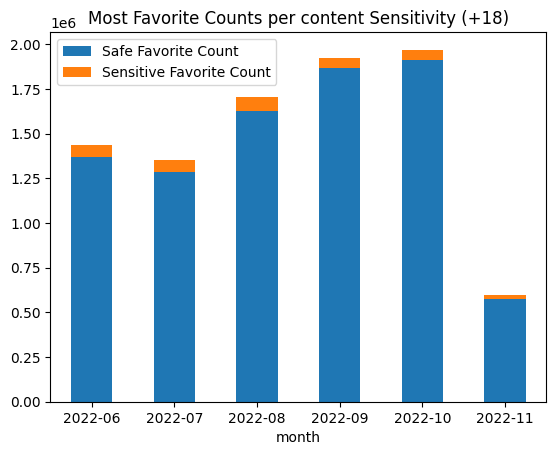

In [10]:
title = 'Most Favorite Counts per content Sensitivity (+18)'

ax = favorites_df.groupby(['month', 'possibly_sensitive']).agg(
    favorite_count=('favorite_count', 'sum')
).reset_index().pivot(
    index='month', 
    columns=['possibly_sensitive']
).plot.bar(stacked=True, title=title, rot=0)
ax.legend(['Safe Favorite Count', 'Sensitive Favorite Count'], title=None)
plt.show()

## month + user_id + favorite_count
  - What users have the most favorite count in total?

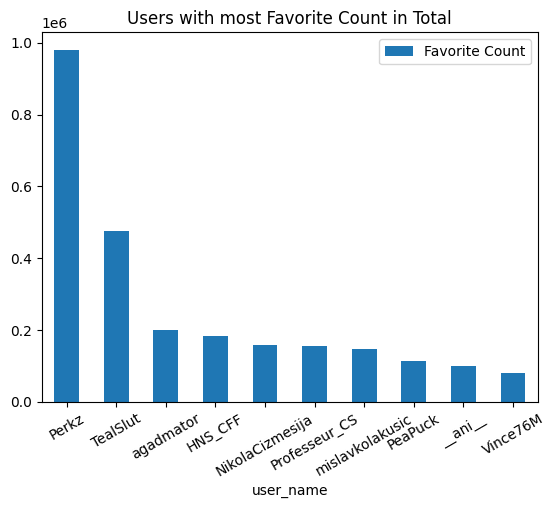

In [11]:
title = 'Users with most Favorite Count in Total'

gdf = favorites_df.groupby('user_name').agg(
    favorite_count=('favorite_count', 'sum')
).sort_values('favorite_count', ascending=False).rename(
    columns={'favorite_count': 'Favorite Count'}
).head(10)

gdf.plot.bar(rot=30, title=title)
plt.show()

In [12]:
gdf.join(users_df[['screen_name', 'description']].set_index('screen_name')).rename(
    columns={'description': 'Description'}
)[['Description', 'Favorite Count']]

,Description,Favorite Count
user_name,,
Perkz,🇭🇷 24 years old. Professional League of Legend...,980304
TealSlut,2020 gonna be my year. @tealslutpriv,476329
agadmator,Owner and content creator of agadmator's Chess...,199055
HNS_CFF,Službeni Twitter profil Hrvatskog nogometnog s...,183187
NikolaCizmesija,Comic and illustration artist at DC comics Sw...,157317
Professeur_CS,Head of Operations @hltvorg @HLTVconfirmed co...,154517
mislavkolakusic,"Member of the European Parliament, former judg...",147710
PeaPuck,Pam & Paolo Puck 🐸🐸 artist duo ✨🔮✨ Paolo make...,112954
__ani__,artist (新人アニメーター ) │commissions closed conta...,100372


  - What users have the most favorite count on a monthly basis?

/tmp/ipykernel_1857834/3301947567.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  gdf.loc[(month, )].head(5).plot(kind='pie', y='Favorite Count', ax=axs[k][j], legend=None)


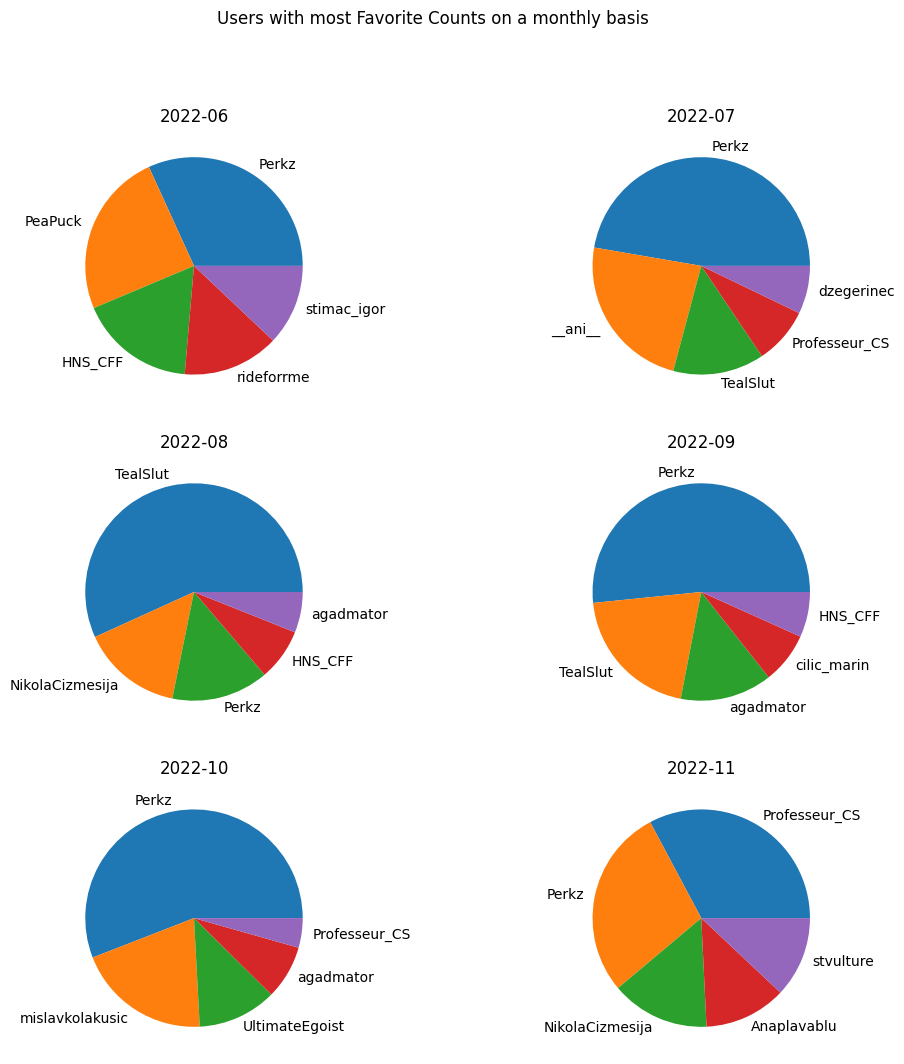

In [13]:
unique_months = favorites_df.index.get_level_values('month').unique()
fig, axs = plt.subplots(nrows=int(len(unique_months)/2), ncols=2, figsize=(12, len(unique_months)*2))
plt.suptitle('Users with most Favorite Counts on a monthly basis')

gdf = favorites_df.groupby(['month', 'user_name']).agg(
    favorite_count=('favorite_count', 'sum')
).sort_values(['month', 'favorite_count'], ascending=False).rename(
    columns={'favorite_count': 'Favorite Count'}
)

max_favorite_count = max(gdf['Favorite Count']) + 10000

j, k = 0, -1
for i, month in enumerate(unique_months):
    if i % 2 == 0: j = 0
    else: j = 1
    
    if j == 0: k += 1
    
    gdf.loc[(month, )].head(5).plot(kind='pie', y='Favorite Count', ax=axs[k][j], legend=None)
    axs[k][j].set_title(month)
    axs[k][j].set_ylabel(None)


plt.show()

## month + favorite_count + hashtags
  - What hashtags have the most favorite count in total?
  - What hashtags have the most favorite count on a monthly basis?

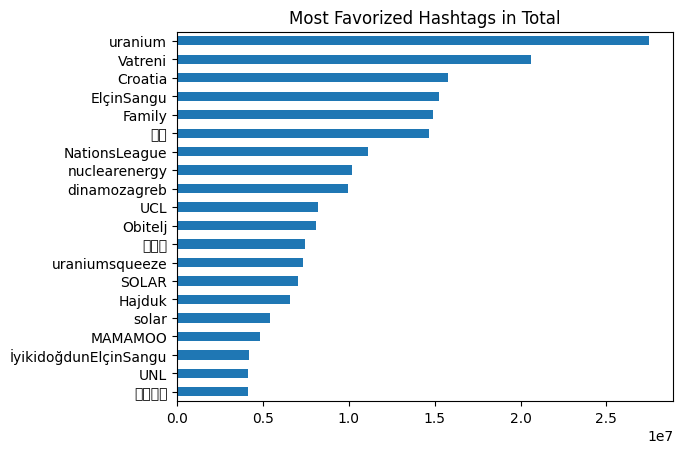

In [14]:
import warnings
warnings.filterwarnings('ignore')

ax = favorites_df[['favorite_count', 'hashtags']].explode(
    ['hashtags']
).dropna().groupby('hashtags').agg(
    favorite_count=('favorite_count', 'sum')
).sort_values('favorite_count', ascending=False).head(20)[::-1] \
 .plot(kind='barh', y='favorite_count', legend=None)

ax.set_ylabel(None)
ax.set_title('Most Favorized Hashtags in Total')
plt.show()

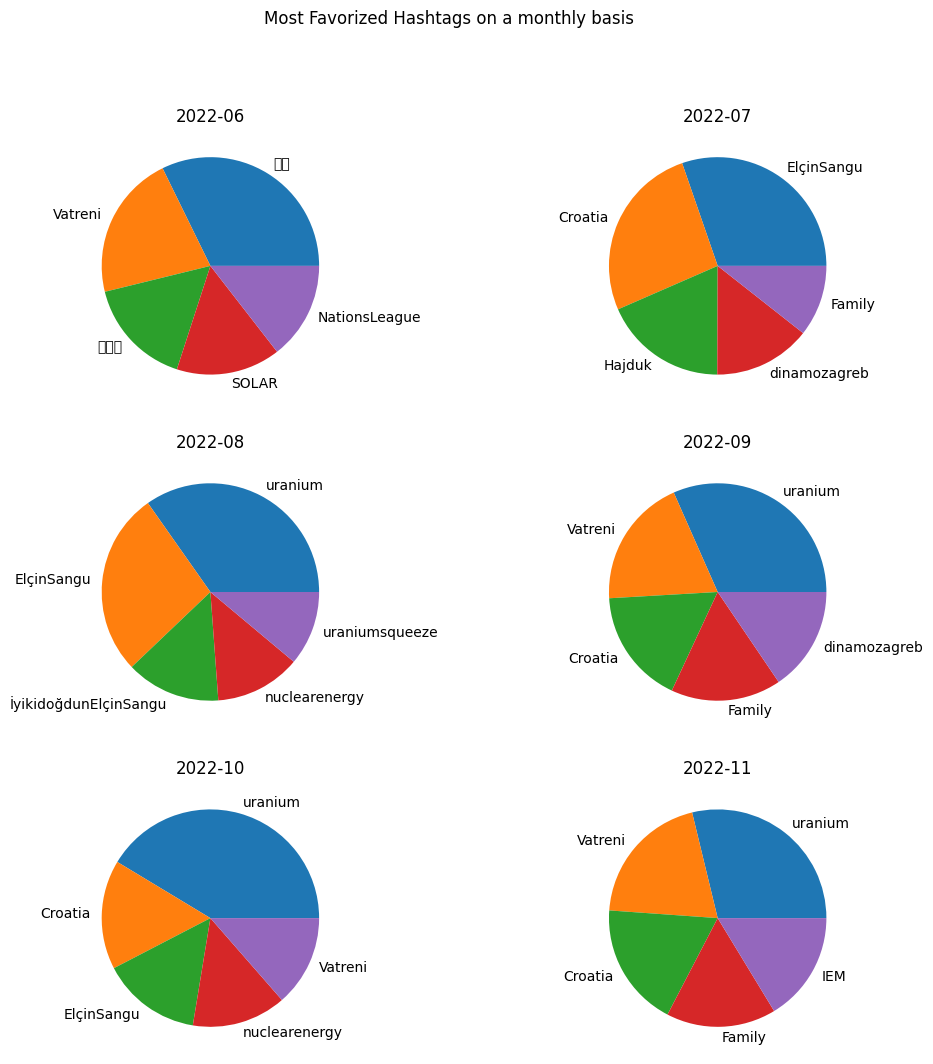

In [26]:
unique_months = favorites_df.index.get_level_values('month').unique()
fig, axs = plt.subplots(nrows=int(len(unique_months)/2), ncols=2, figsize=(12, len(unique_months)*2))
plt.suptitle('Most Favorized Hashtags on a monthly basis')

gdf = favorites_df[['favorite_count', 'hashtags']].explode(
    ['hashtags']
).dropna().groupby(['month', 'hashtags']).agg(
    favorite_count=('favorite_count', 'sum')
).sort_values(['month', 'favorite_count'], ascending=False).rename(
    columns={'favorite_count': 'Favorite Count'}
)

max_favorite_count = max(gdf['Favorite Count']) + 10000

j, k = 0, -1
for i, month in enumerate(unique_months):
    if i % 2 == 0: j = 0
    else: j = 1
    
    if j == 0: k += 1
    
    gdf.loc[(month, )].head(5).plot(kind='pie', y='Favorite Count', ax=axs[k][j], legend=None)
    axs[k][j].set_title(month)
    axs[k][j].set_ylabel(None)

plt.show()

# Hashtags

In [36]:
hashtags_view = tweets_view[['id', 'user_name', 'month', 'hashtags', 'is_retweet', 'is_reply']].explode('hashtags').dropna()
month_htag_df = hashtags_view[['month', 'hashtags']].groupby(['month', 'hashtags']).size()

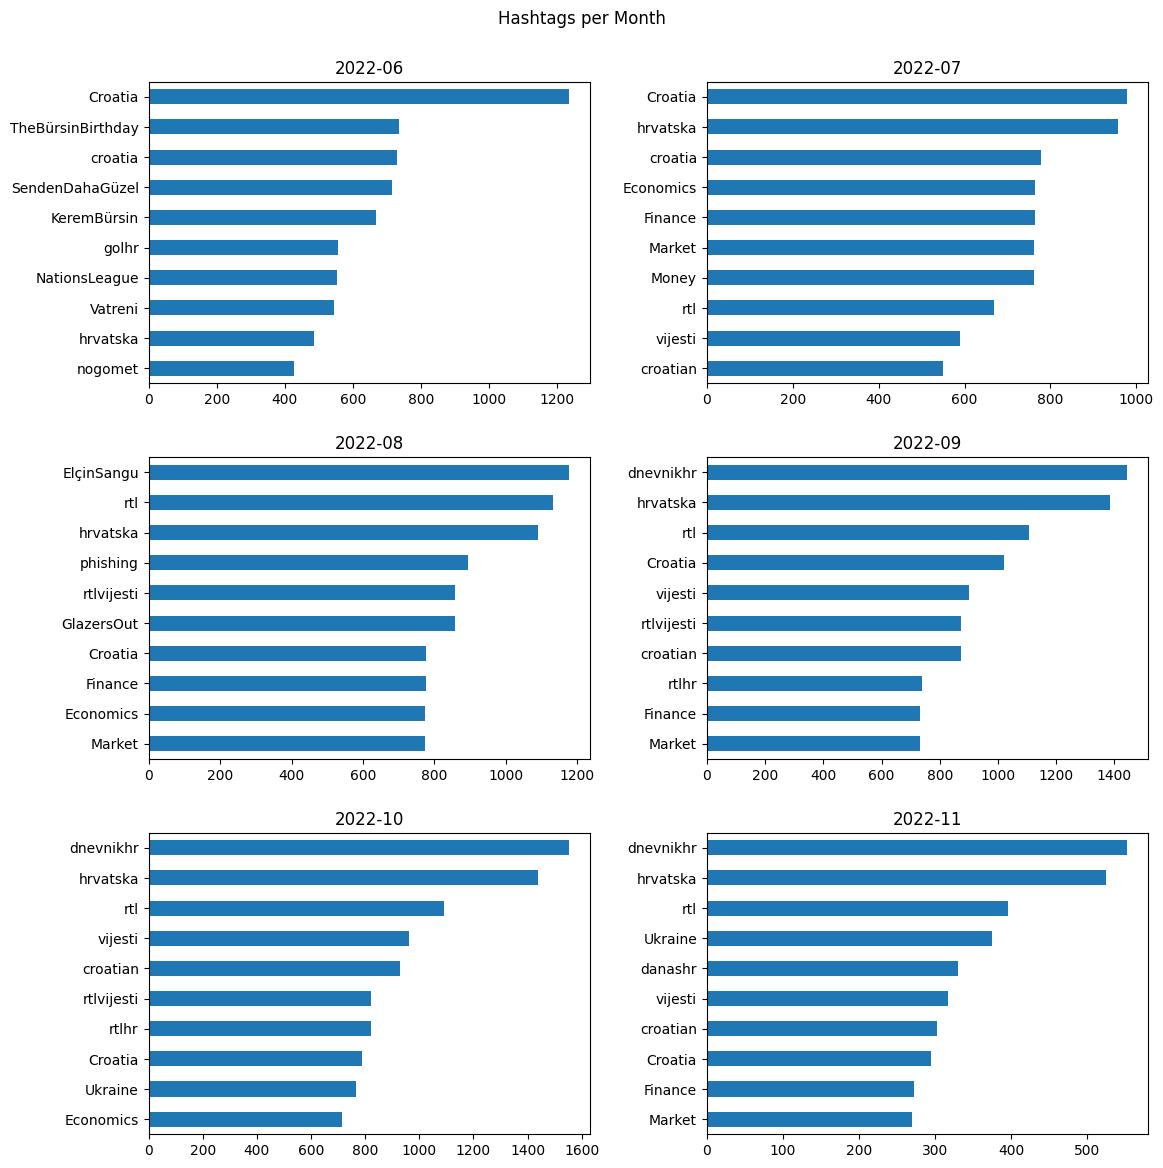

In [29]:
unique_months = tweets_view.month.unique()[::-1]
fig, axs = plt.subplots(nrows=int(len(unique_months)/2), ncols=2, figsize=(12, len(unique_months)*2))
plt.suptitle("Hashtags per Month")

j, k = 0, -1
for i, month in enumerate(unique_months):
    if i % 2 == 0: j = 0
    else: j = 1
    
    if j == 0: k += 1
    
    month_htag_df.loc[(month,)].sort_values().tail(10) \
      .plot.barh(ax=axs[k][j])
    axs[k][j].set_title(month)
    axs[k][j].set_ylabel(None)

fig.tight_layout(pad=2)
plt.show()

In [40]:
hashtags_view.groupby(['month', 'hashtags']).agg(
    hashtags=('hashtags', 'size'),
    is_retweet=('is_retweet', 'sum'),
    is_reply=('is_reply', 'sum'),
    total=('id', 'size')
).sort_values(['month', 'total'], ascending=False)

hashtags  is_retweet  is_reply  total
month   hashtags                                           
2022-11 dnevnikhr          552          92         0    552
        hrvatska           525          13         0    525
        rtl                396           1         0    396
        Ukraine            375         323        10    375
        danashr            330           0         0    330
...                        ...         ...       ...    ...
2022-06 𝗦𝗶𝗻𝘀𝗮𝘆               1           0         0      1
        𝗧𝗼𝗺𝗧𝗮𝗶𝗹𝗼𝗿            1           0         0      1
        𝗩𝗼𝗹𝘂𝗻𝘁𝗲𝗲𝗿𝗶𝗻𝗴         1           1         0      1
        𝗯𝗮𝗿𝗲𝗯𝗮𝗰𝗸             1           1         0      1
        𝙲𝚊𝚛𝚍𝚊𝚗𝚘              1           1         0      1

[168312 rows x 4 columns]

In [ ]:
# hashtags_df = tweets_view[['user_name', 'month', 'hashtags']].explode('hashtags').dropna()
month_users_htag_df = tweets_view[tweets_view['is_retweet'] == False][['month', 'user_name', 'hashtags']].groupby(['month', 'user_name']).sum()
month_htag_df = month_users_htag_df.groupby('month').sum()

In [19]:
hashtags_df = tweets_view[['user_name', 'hashtags']].copy()
hashtags_df['count_hashtags'] = hashtags_df['hashtags'].transform(lambda x: len(x))
hashtags_df = hashtags_df[hashtags_df['count_hashtags'] > 3]
hashtags_df.sample(20)#.sort_values('count_hashtags', ascending=False)

,user_name,hashtags,count_hashtags
1432361,nenadzanko,"[KualaLumpur, MasjidNegara, NationalMosque, Ma...",9
1816771,ana88cro,"[blonde, highheels, white, body, blonde, high,...",10
1345547,golhr,"[dinamo, ligaprvaka, nogomet, golhr]",4
482790,danas_hr,"[rtl, rtlhr, rtlvijesti, vrijeme, prognoza, hr...",6
1352789,eruanna7,"[jhope, 제이홉, JackInTheBox, jhope_MORE]",4
1233602,vuk_san,"[artteacher, artworkshop, stupnik, likovneradi...",5
1269390,ivek69,"[butts, arse, butt, bottoms, blondeshavemorefu...",10
783579,PIXSELL,"[arijanademi, dinamo, caosvima, dinamo, zagreb...",8
784052,PIXSELL,"[goodmorning, morning, caosvima, jutro, dobroj...",13
1414972,Danijel80976550,"[zimohr, whatsapp, društvenemreže, aplikacija]",4


In [20]:
hashtags_df = hashtags_df[['user_name', 'hashtags']].sample(200).explode('hashtags').dropna()
hashtags_pivot = hashtags_df.pivot_table(index='user_name', columns=['hashtags'], aggfunc=len).fillna(0)
hashtags_pivot

hashtags,10wordjournal,2014년연습일지,2022BTSFESTA,2022HDA,50POEMSFORSNOW,ADA,AI,APR,ASPNET,ATEEZ,...,연습실소년단,오늘의TXT,용타하리,채현,투모로우바이투게더,펜타곤,플로운,하트드림어워즈,허윤진,화사
user_name,,,,,,,,,,,,,,,,,,,,,
9a2ki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AlenKarabegovic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andrea_C_White,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AndrejaMetelko,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AnimalsWBorders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ultra_010699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unikatikeramika,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vatreni_token,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## month + hashtags
  - What are the most frequently used hashtags on a monthly basis?
## hashtags + user_id
  - What hashtags are linked to a user on average in total?
  - What hashtags are linked to a user on average on a monthly basis?

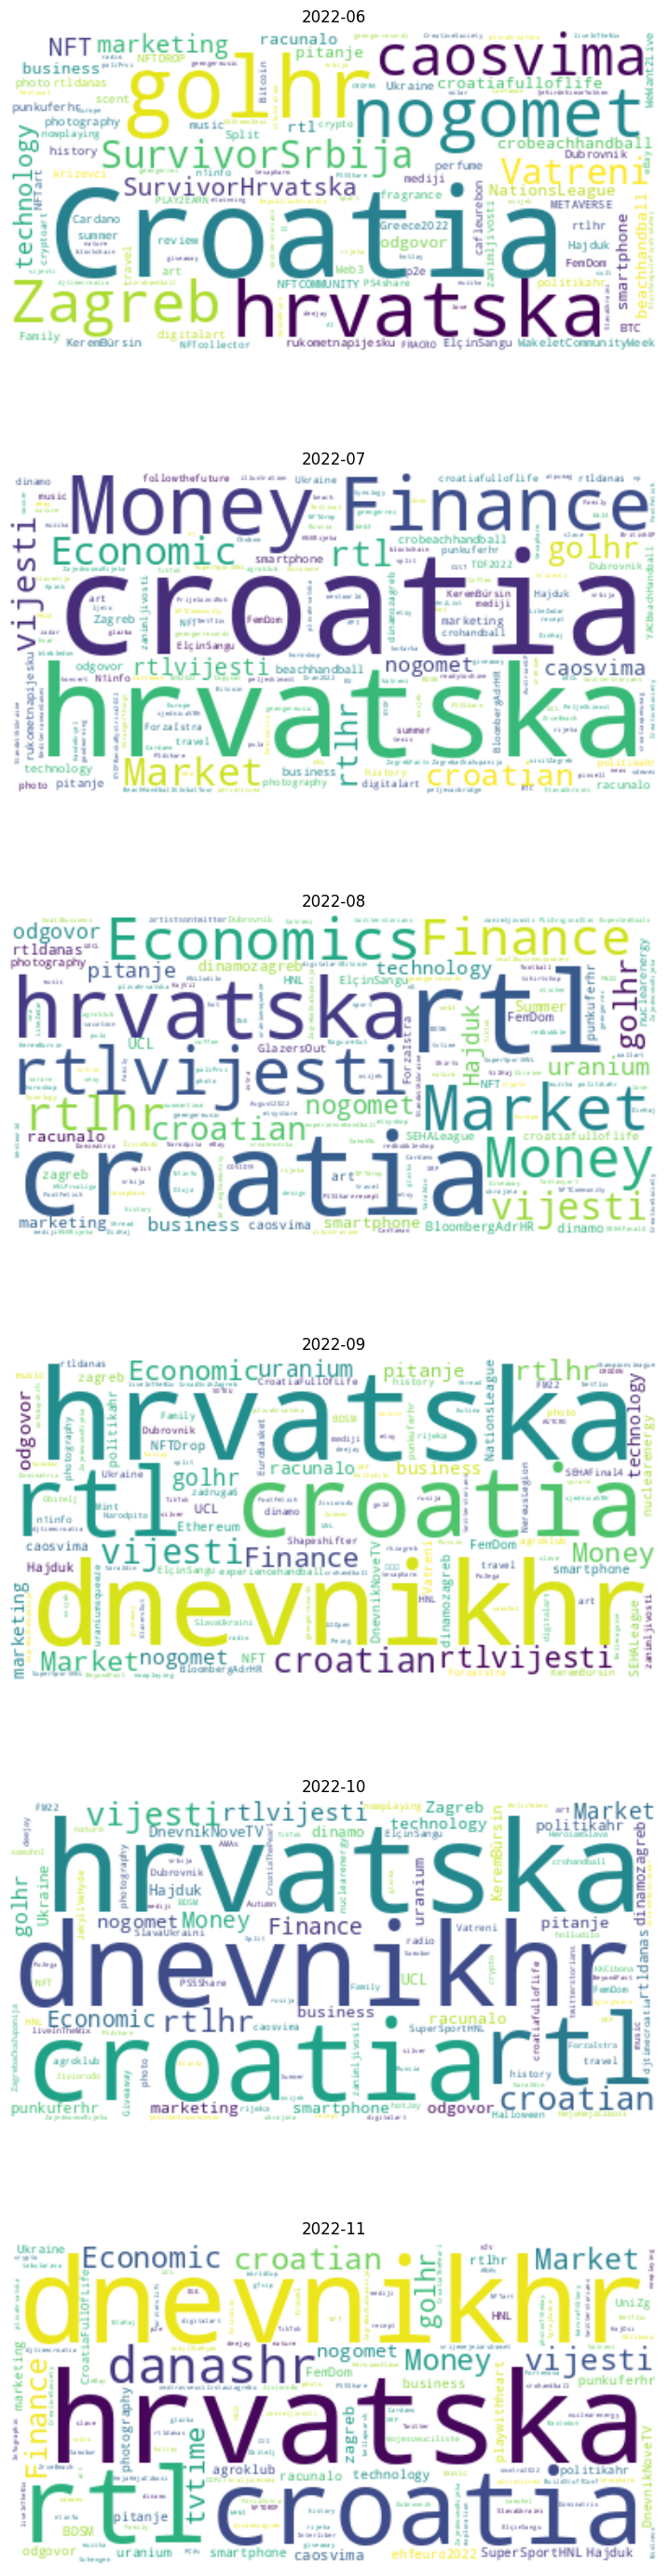

In [21]:
from wordcloud import WordCloud

unique_months = month_htag_df.index
fig, axs = plt.subplots(len(unique_months), figsize=(9, len(unique_months)*6))

for i, month in enumerate(unique_months):
    string = " ".join(month_htag_df.loc[month, 'hashtags'])
    wordcloud = WordCloud(collocations=False, background_color='white').generate(string)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(month)
    axs[i].axis('off')
plt.show()

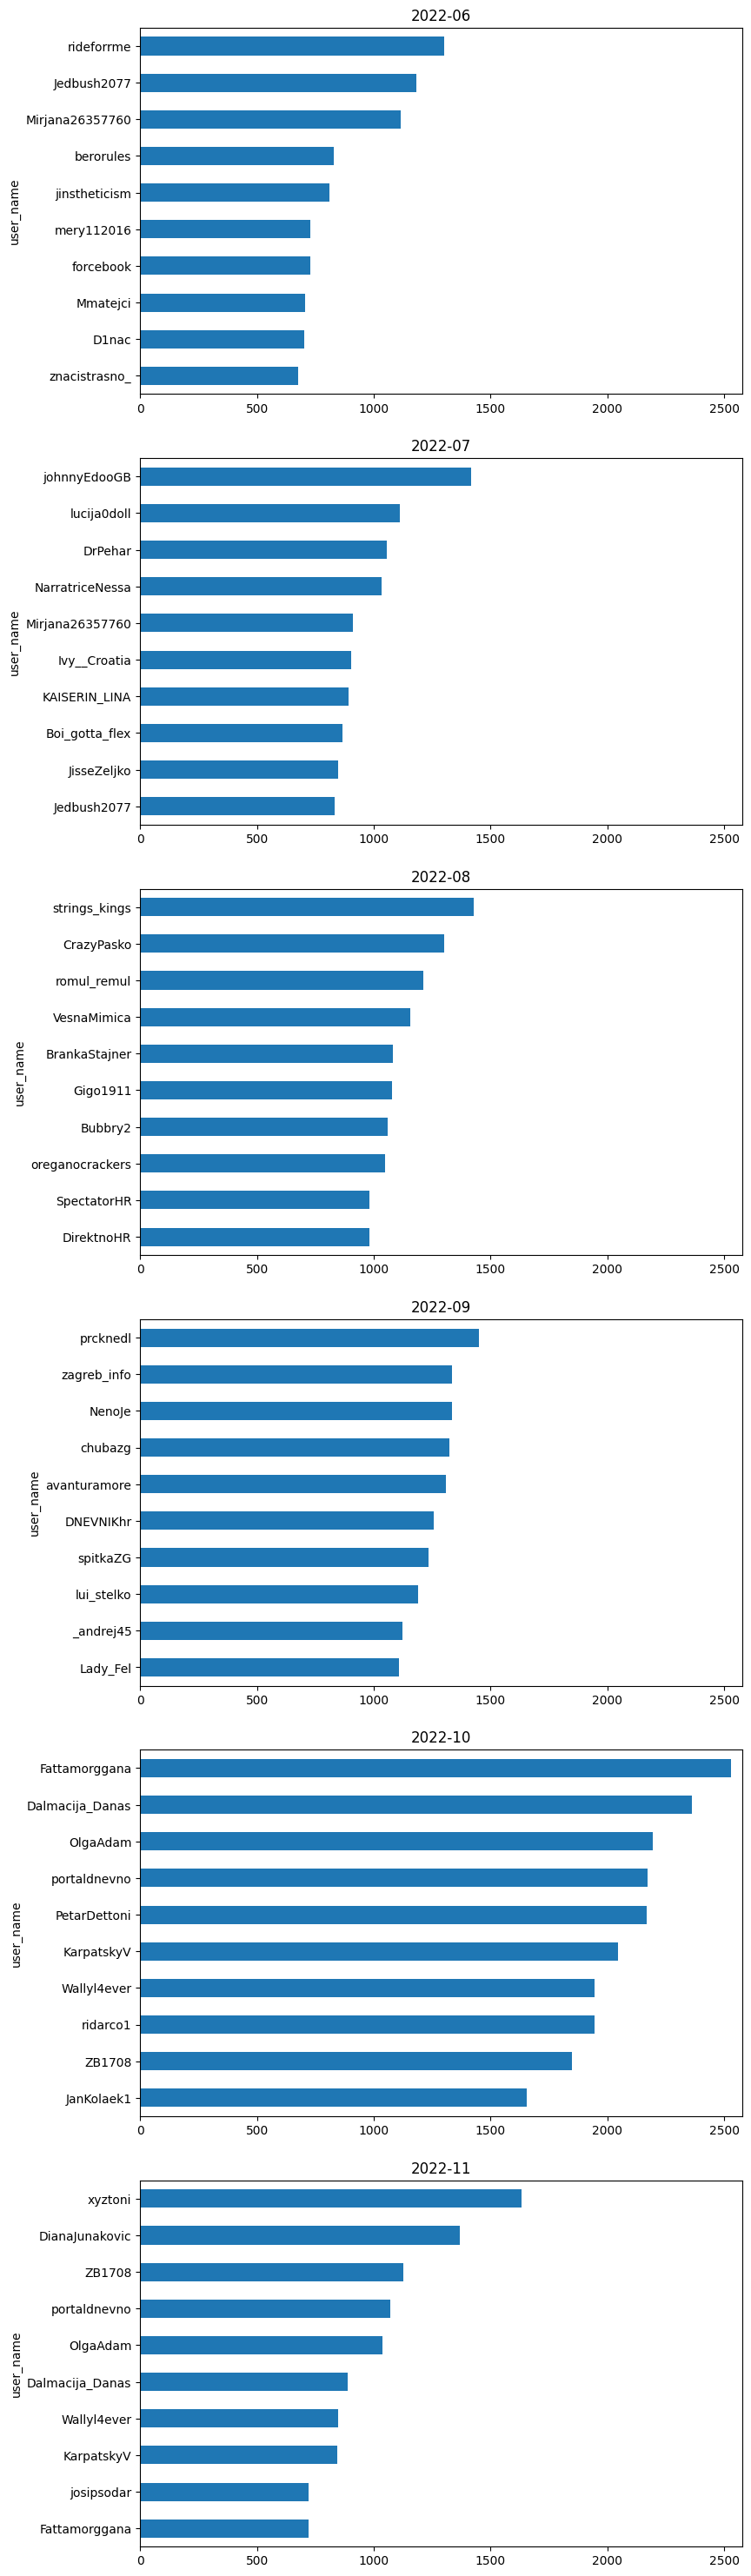

In [22]:
unique_months = tweets_view.month.unique()
fig, axs = plt.subplots(len(unique_months), figsize=(9, len(unique_months) * 5))

plt.title('Tweet Distribution per Month by User')

top_tweeters = tweets_view[tweets_view['is_retweet'] == False][[
    'month', 'user_name'
]].groupby(['month', 'user_name']).size()
max_tweets = top_tweeters.max()

for i, month in enumerate(unique_months[::-1]):
    top_tweeters.loc[(month, )].sort_values().tail(10).plot.barh(ax=axs[i])
    axs[i].set_title(month)
    axs[i].set_xlim(xmin=0, xmax=max_tweets+50)

fig.tight_layout(pad=2)
plt.show()


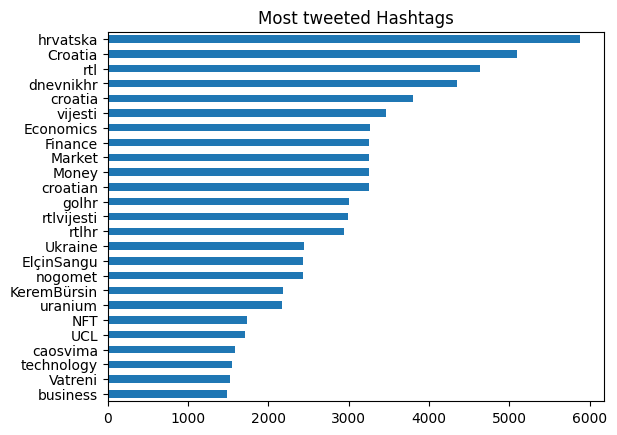

In [23]:
fig, ax = plt.subplots(1, figsize=None)

htag_count = tweets_view['hashtags'].explode().dropna().value_counts()
htag_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most tweeted Hashtags')
plt.show()

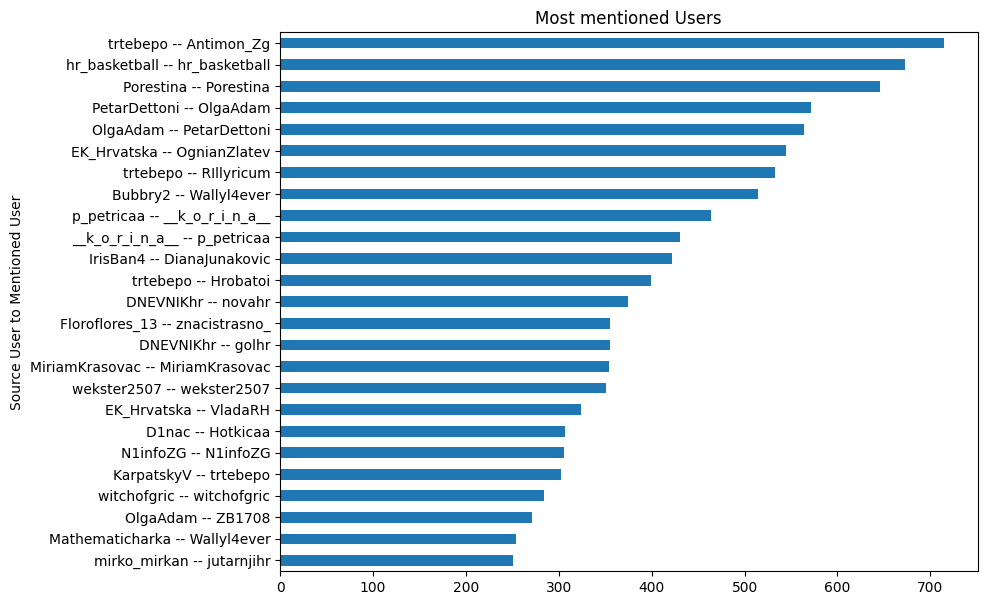

In [24]:
fig, ax = plt.subplots(1, figsize=(9, 7))

ument_count = tweets_view[['user_id', 'user_mentions']].explode('user_mentions').dropna()
ument_count = ument_count.merge(users_df[['user_id', 'screen_name']], how='inner', on='user_id')
ument_count = ument_count.merge(users_df[['user_id', 'screen_name']], how='left', left_on='user_mentions', right_on='user_id', suffixes=['_source', '_target'])
ument_count = ument_count.groupby(['screen_name_source', 'screen_name_target']).size().sort_values(ascending=False)
ument_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most mentioned Users')
ax.set_ylabel('Source User to Mentioned User')
ax.set_yticklabels(["{} -- {}".format(src, tgt) for src, tgt in ument_count.head(25).iloc[::-1].index])
plt.show()

In [25]:
retweet_view = tweets_df[[
    'id', 
    'user_id', 
    'created_at', 
    'full_text', 
    'retweet_from_user_id', 
    'retweet_from_tweet_id', 
    'retweet_created_at'
]].rename(columns={
    'id':                   'rt_tweet_id', 
    'user_id':              'rt_user_id', 
    'created_at':           'rt_created_at', 
    'full_text':            'full_text', 
    'retweet_created_at':   'og_created_at',
    'retweet_from_user_id': 'og_user_id', 
    'retweet_from_tweet_id': 'og_tweet_id'
}).merge()

TypeError: merge() missing 1 required positional argument: 'right'

In [ ]:
tweets_df.groupby('user_id').size()
# .agg(total_tweets=('user_id', 'size')).join(user_df.set_index('user_id'), how='inner')